In [12]:
# useful libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# pyspark libs
from pyspark import SparkContext

from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.mllib.feature import StandardScaler, Normalizer, HashingTF, IDF
from pyspark.mllib.linalg import Vectors, SparseVector
from pyspark.mllib.stat import Statistics

from pyspark.ml.feature import StringIndexer, VectorIndexer, Imputer

In [13]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation

In [14]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql import SQLContext, SparkSession, Row, Window

In [15]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, Tokenizer, HashingTF, IDF
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import when

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler



#### Load the pre-processed dataframe

In [16]:
ss = SparkSession.builder.appName("clustering").getOrCreate()

In [17]:
# Read the CSV file with multiline values (description and facilities)
data = ss.read.options(header = True, inferSchema = True, multiline = True, escape = "\"").csv("dataframe_totalCleaned.csv")
# Show the corrected description and facilities fields
data.count(),len(data.columns)

(188417, 27)

In [19]:
#cast geo_plz

from pyspark.sql.functions import col
data = data.withColumn("geo_plz", col("geo_plz").cast("string"))
data = data.withColumn("geo_plz", col("geo_plz").cast("int"))

#### Silhouette and Elbow method on: 
##### log_yearConstructed, log_noRooms, log_floor, log_numberOfFloors, log_serviceCharge,
##### log_baseRent, log_livingSpace, log_thermalChar

In [20]:
data.dtypes

[('regio1', 'string'),
 ('heatingType', 'string'),
 ('balcony', 'boolean'),
 ('firingTypes', 'string'),
 ('hasKitchen', 'boolean'),
 ('cellar', 'boolean'),
 ('condition', 'string'),
 ('interiorQual', 'string'),
 ('petsAllowed', 'string'),
 ('streetPlain', 'string'),
 ('lift', 'boolean'),
 ('typeOfFlat', 'string'),
 ('geo_plz', 'int'),
 ('garden', 'boolean'),
 ('regio2', 'string'),
 ('regio3', 'string'),
 ('description', 'string'),
 ('facilities', 'string'),
 ('log_pictureCount', 'double'),
 ('log_yearConstructed', 'double'),
 ('log_noRooms', 'double'),
 ('log_floor', 'double'),
 ('log_numberOfFloors', 'double'),
 ('log_serviceCharge', 'double'),
 ('log_baseRent', 'double'),
 ('log_livingSpace', 'double'),
 ('log_thermalChar', 'double')]

In [21]:
#drop strings data and selected columns
data_clustering=data.drop('regio1','heatingType','balcony','firingTypes','hasKitchen',
                          'cellar','condition','interiorQual','petsAllowed','streetPlain',
                          'lift','typeOfFlat','geo_plz','garden','regio2','regio3','description',
                          'facilities','log_pictureCount')

#### Assembler

In [22]:
selected_data=data_clustering.columns
# Assemble features into a single column
assembler = VectorAssembler(inputCols=selected_data, outputCol='features')
data = assembler.transform(data_clustering)

#### Silhouette

In [23]:
silhouettes = []
costs = []

#test for 2 to 8 clusters
for k in range (2,8):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(data)
    
    predictions = model.transform(data)
    
    # SS Distance to nearest centroid a.k.a. Inertia (in sklearn) - intra clusters distance 
    cost = model.summary.trainingCost
    costs.append(cost)
    
    # sillhouette score
    evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    
    silhouettes.append(silhouette)

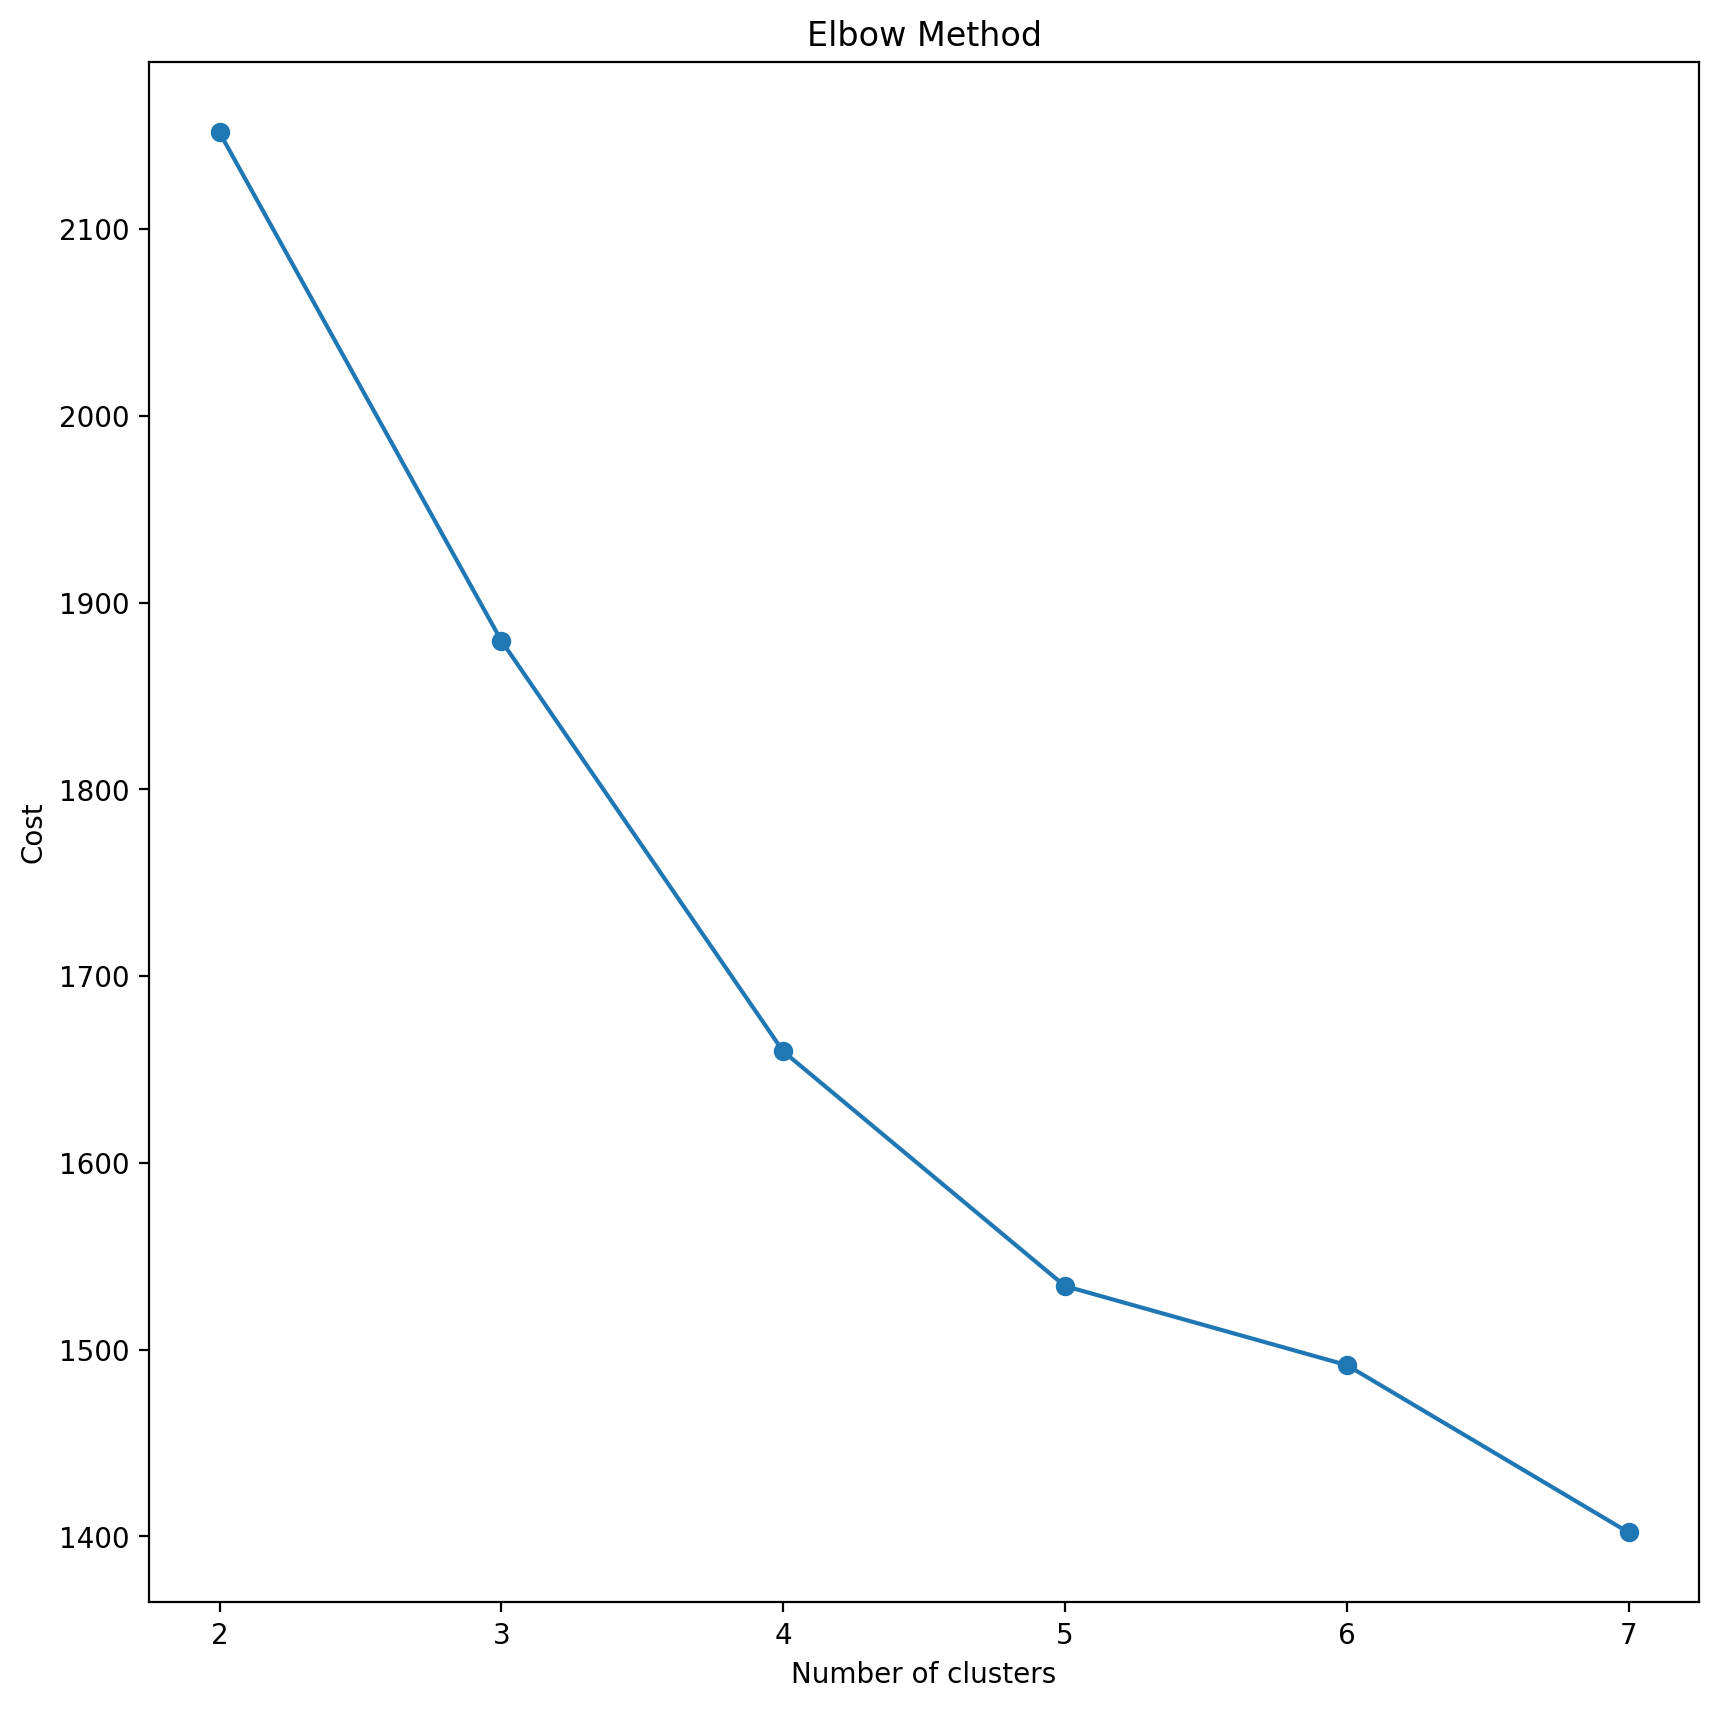

In [24]:
k=range(2,8)

plt.figure(figsize=(10,10), dpi=200)

plt.plot(k, costs)
plt.scatter(k, costs)

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')

plt.savefig('./Inertia.png')
plt.show()

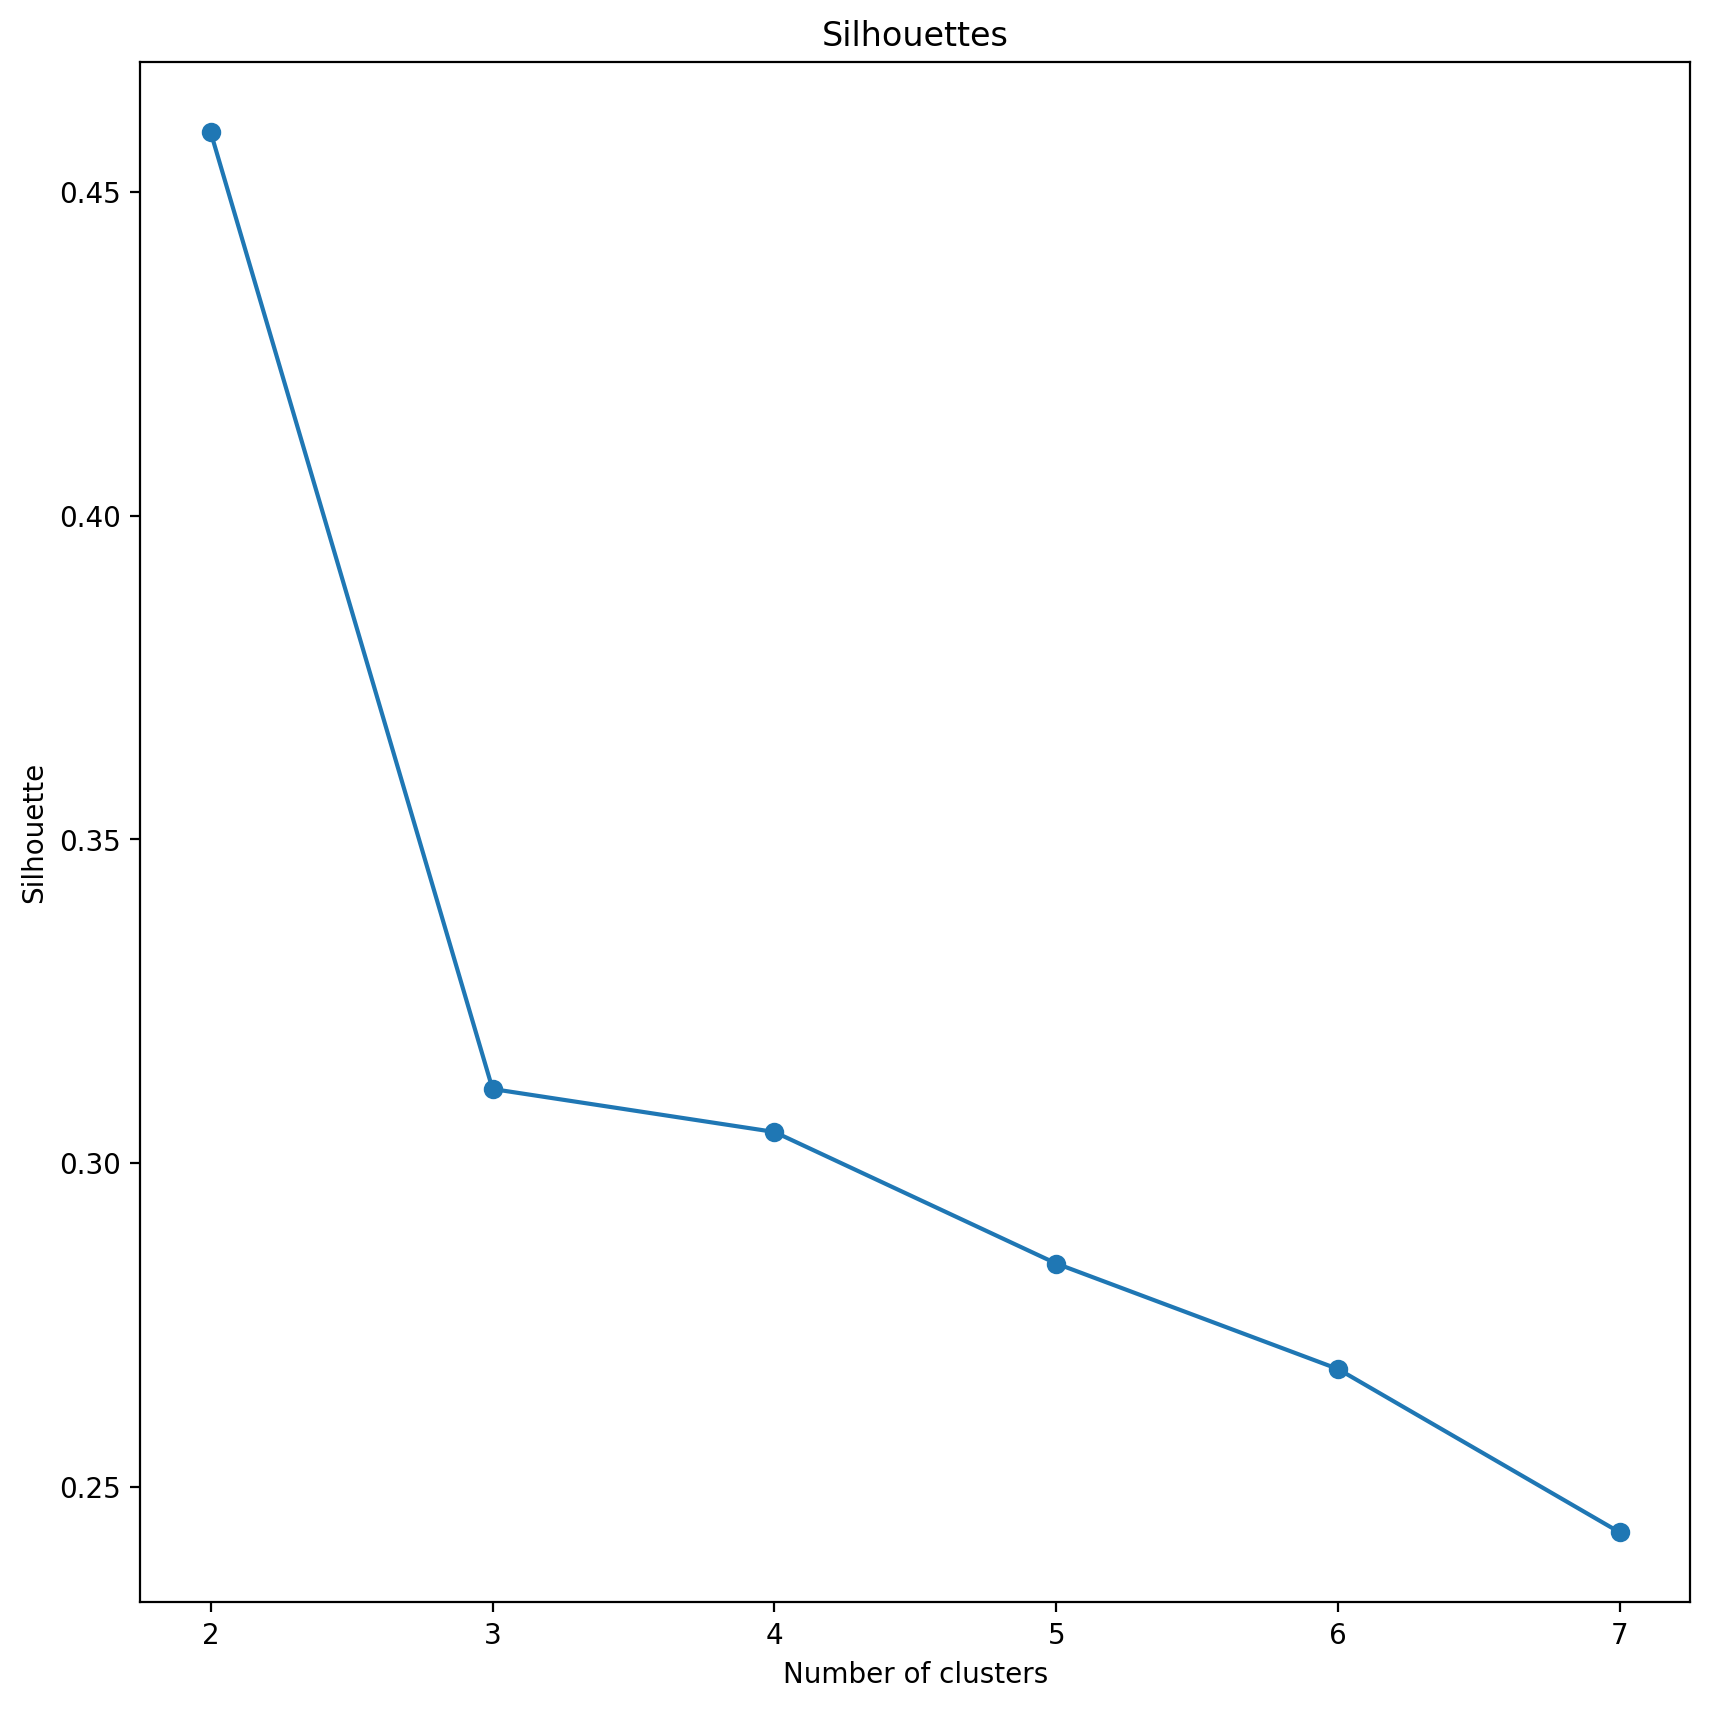

In [25]:
#distance points to the centroid of its cluster
k=range(2,8)

plt.figure(figsize=(10,10), dpi=200)

plt.plot(k, silhouettes)
plt.scatter(k, silhouettes)

plt.title('Silhouettes')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')

plt.savefig('./Silhouettes.png')
plt.show()

In [26]:
#### optimal clusters 3 or 5

#### Clustering on 2 Attributes (Rent & Living Space)

In [27]:
# Read the CSV file with multiline values (description and facilities)
data = ss.read.options(header = True, inferSchema = True, multiline = True, escape = "\"").csv("dataframe_totalCleaned.csv")
# Show the corrected description and facilities fields
data.count(),len(data.columns)

(188417, 27)

In [28]:
#cast geo_plz (again)

from pyspark.sql.functions import col
data = data.withColumn("geo_plz", col("geo_plz").cast("string"))
data = data.withColumn("geo_plz", col("geo_plz").cast("int"))

In [29]:
#drop strings data and selected columns
data_clustering2=data.drop('regio1','heatingType','balcony','firingTypes','hasKitchen',
                          'cellar','condition','interiorQual','petsAllowed','streetPlain',
                          'lift','geo_plz','garden','regio2','regio3','description',
                          'facilities','log_pictureCount','log_yearConstructed','log_noRooms',
                          'log_floor','log_numberOfFloors','log_serviceCharge','log_living_Space',
                          'log_thermalChar','typeOfFlat')

In [30]:
data_clustering2.count(),len(data_clustering2.columns)

(188417, 2)

In [31]:
data_clustering2.show(2)

+--------------------+--------------------+
|        log_baseRent|     log_livingSpace|
+--------------------+--------------------+
|0.058268908123975824|0.058268908123975824|
| 0.04286790022717587| 0.03941300235683506|
+--------------------+--------------------+
only showing top 2 rows



#### Assembler

In [32]:
selected_data=data_clustering2.columns
# Assemble features into a single column
assembler = VectorAssembler(inputCols=selected_data, outputCol='features')
data = assembler.transform(data_clustering2)


In [33]:
#Again, silhouettes and costs evaluation over log_baseRent and log_LivingSpace
silhouettes = []
costs = []

#test for 2 to 8 clusters
for k in range (2,8):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(data)
    
    predicitions = model.transform(data)
    
    # SSE to the nearest centroid a.k.a. Inertia
    cost = model.summary.trainingCost
    costs.append(cost)
    
    # sillhouette score
    evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predicitions)
    
    silhouettes.append(silhouette)

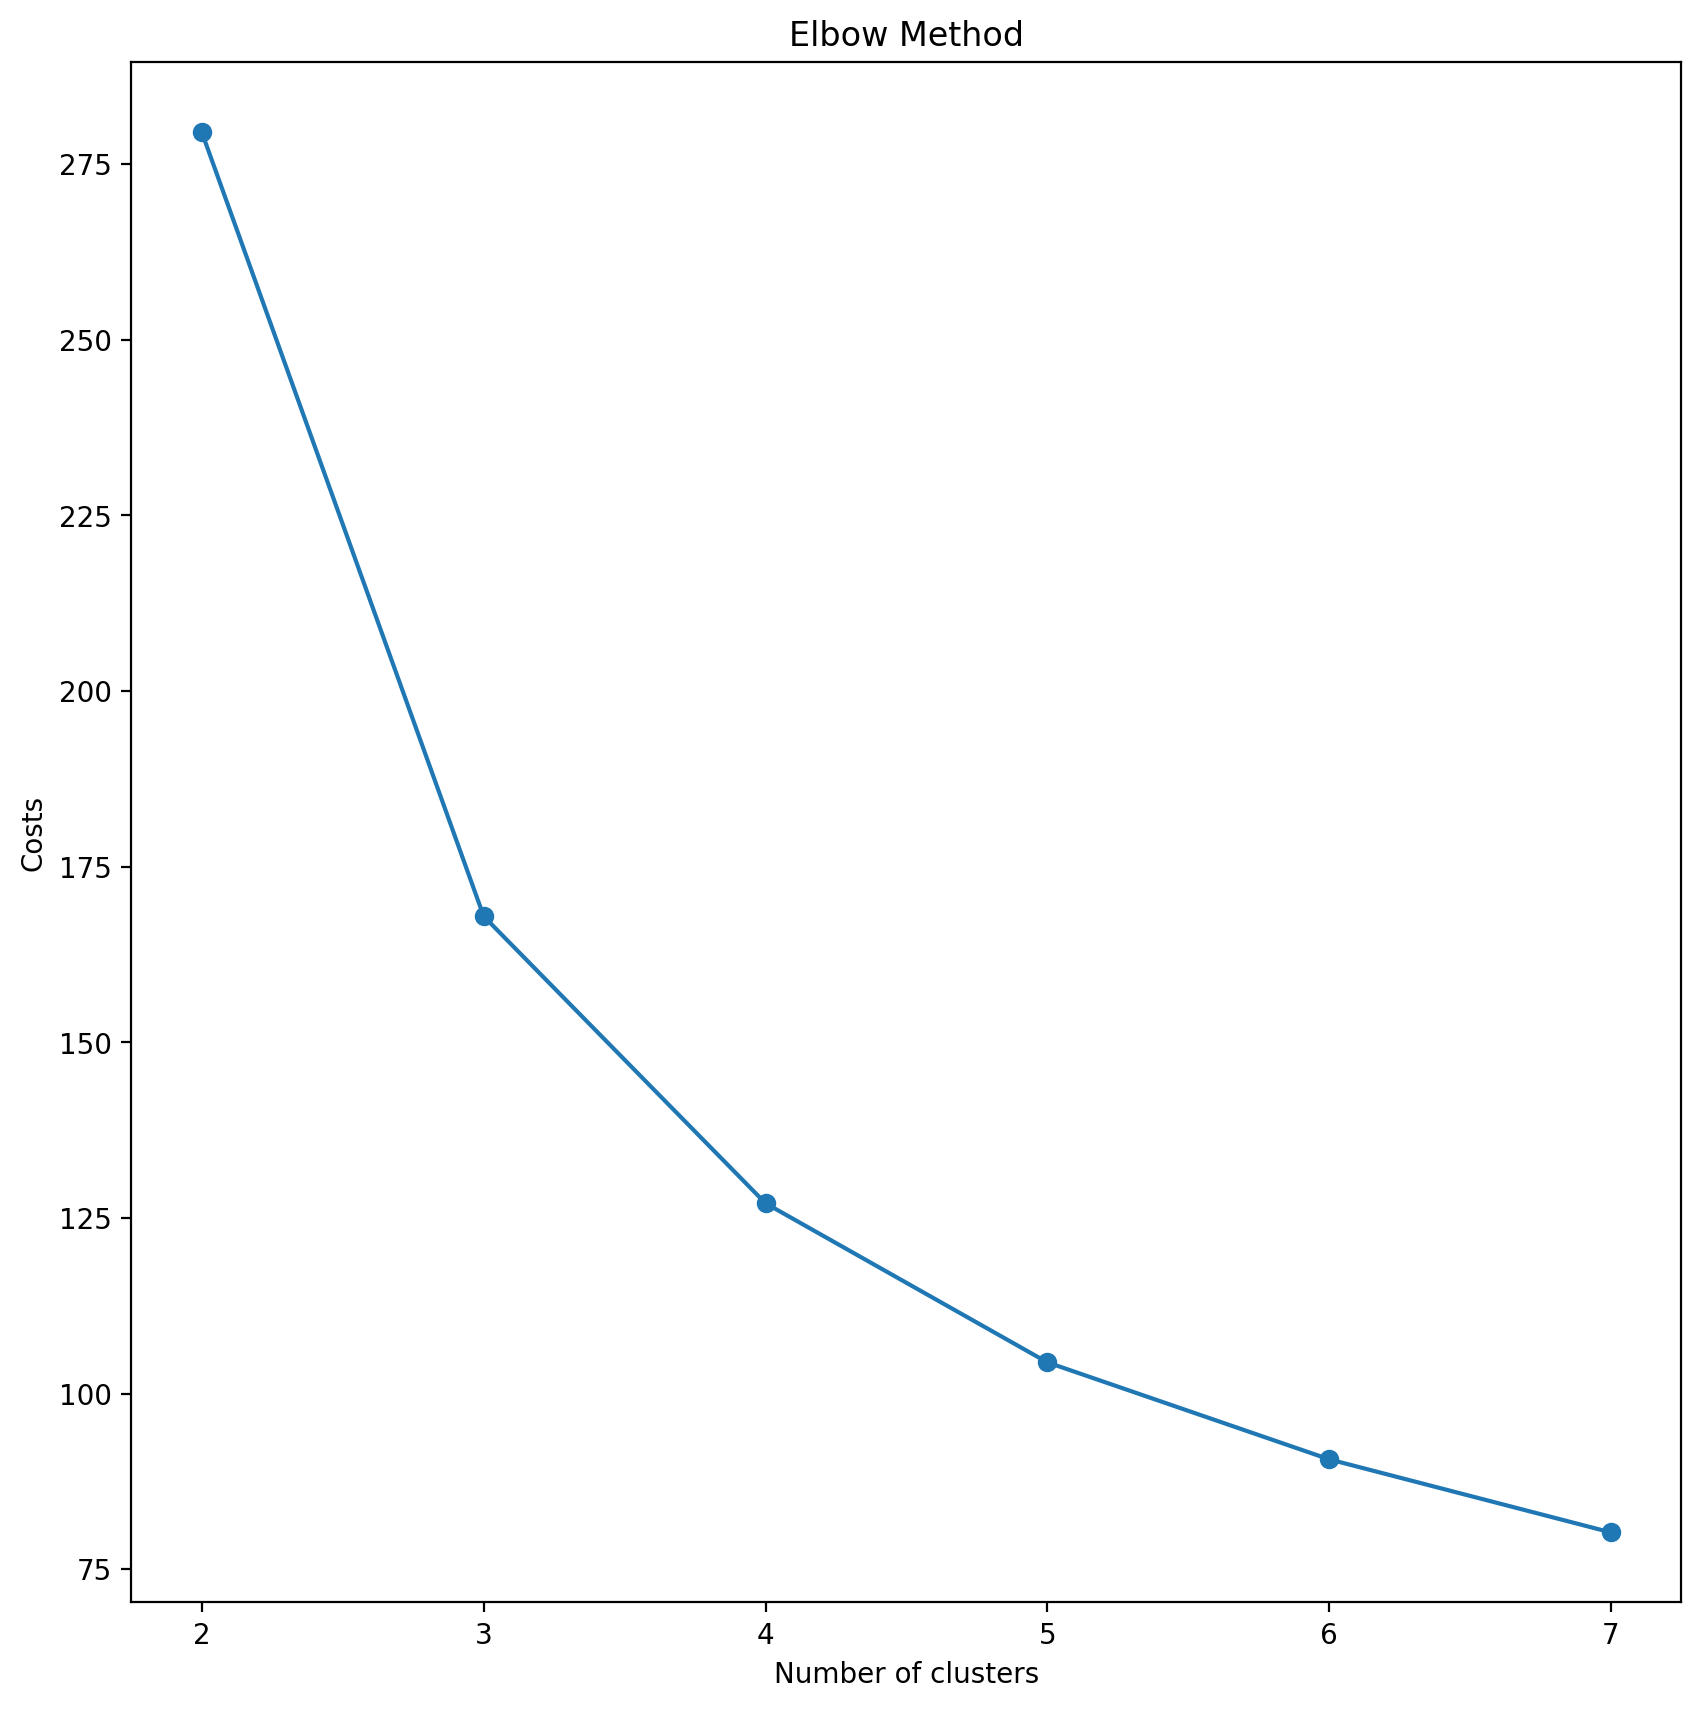

In [34]:
k=range(2,8)

plt.figure(figsize=(10,10), dpi=200)

plt.plot(k, costs)
plt.scatter(k, costs)

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Costs')

plt.savefig('./Cost.png')
plt.show()

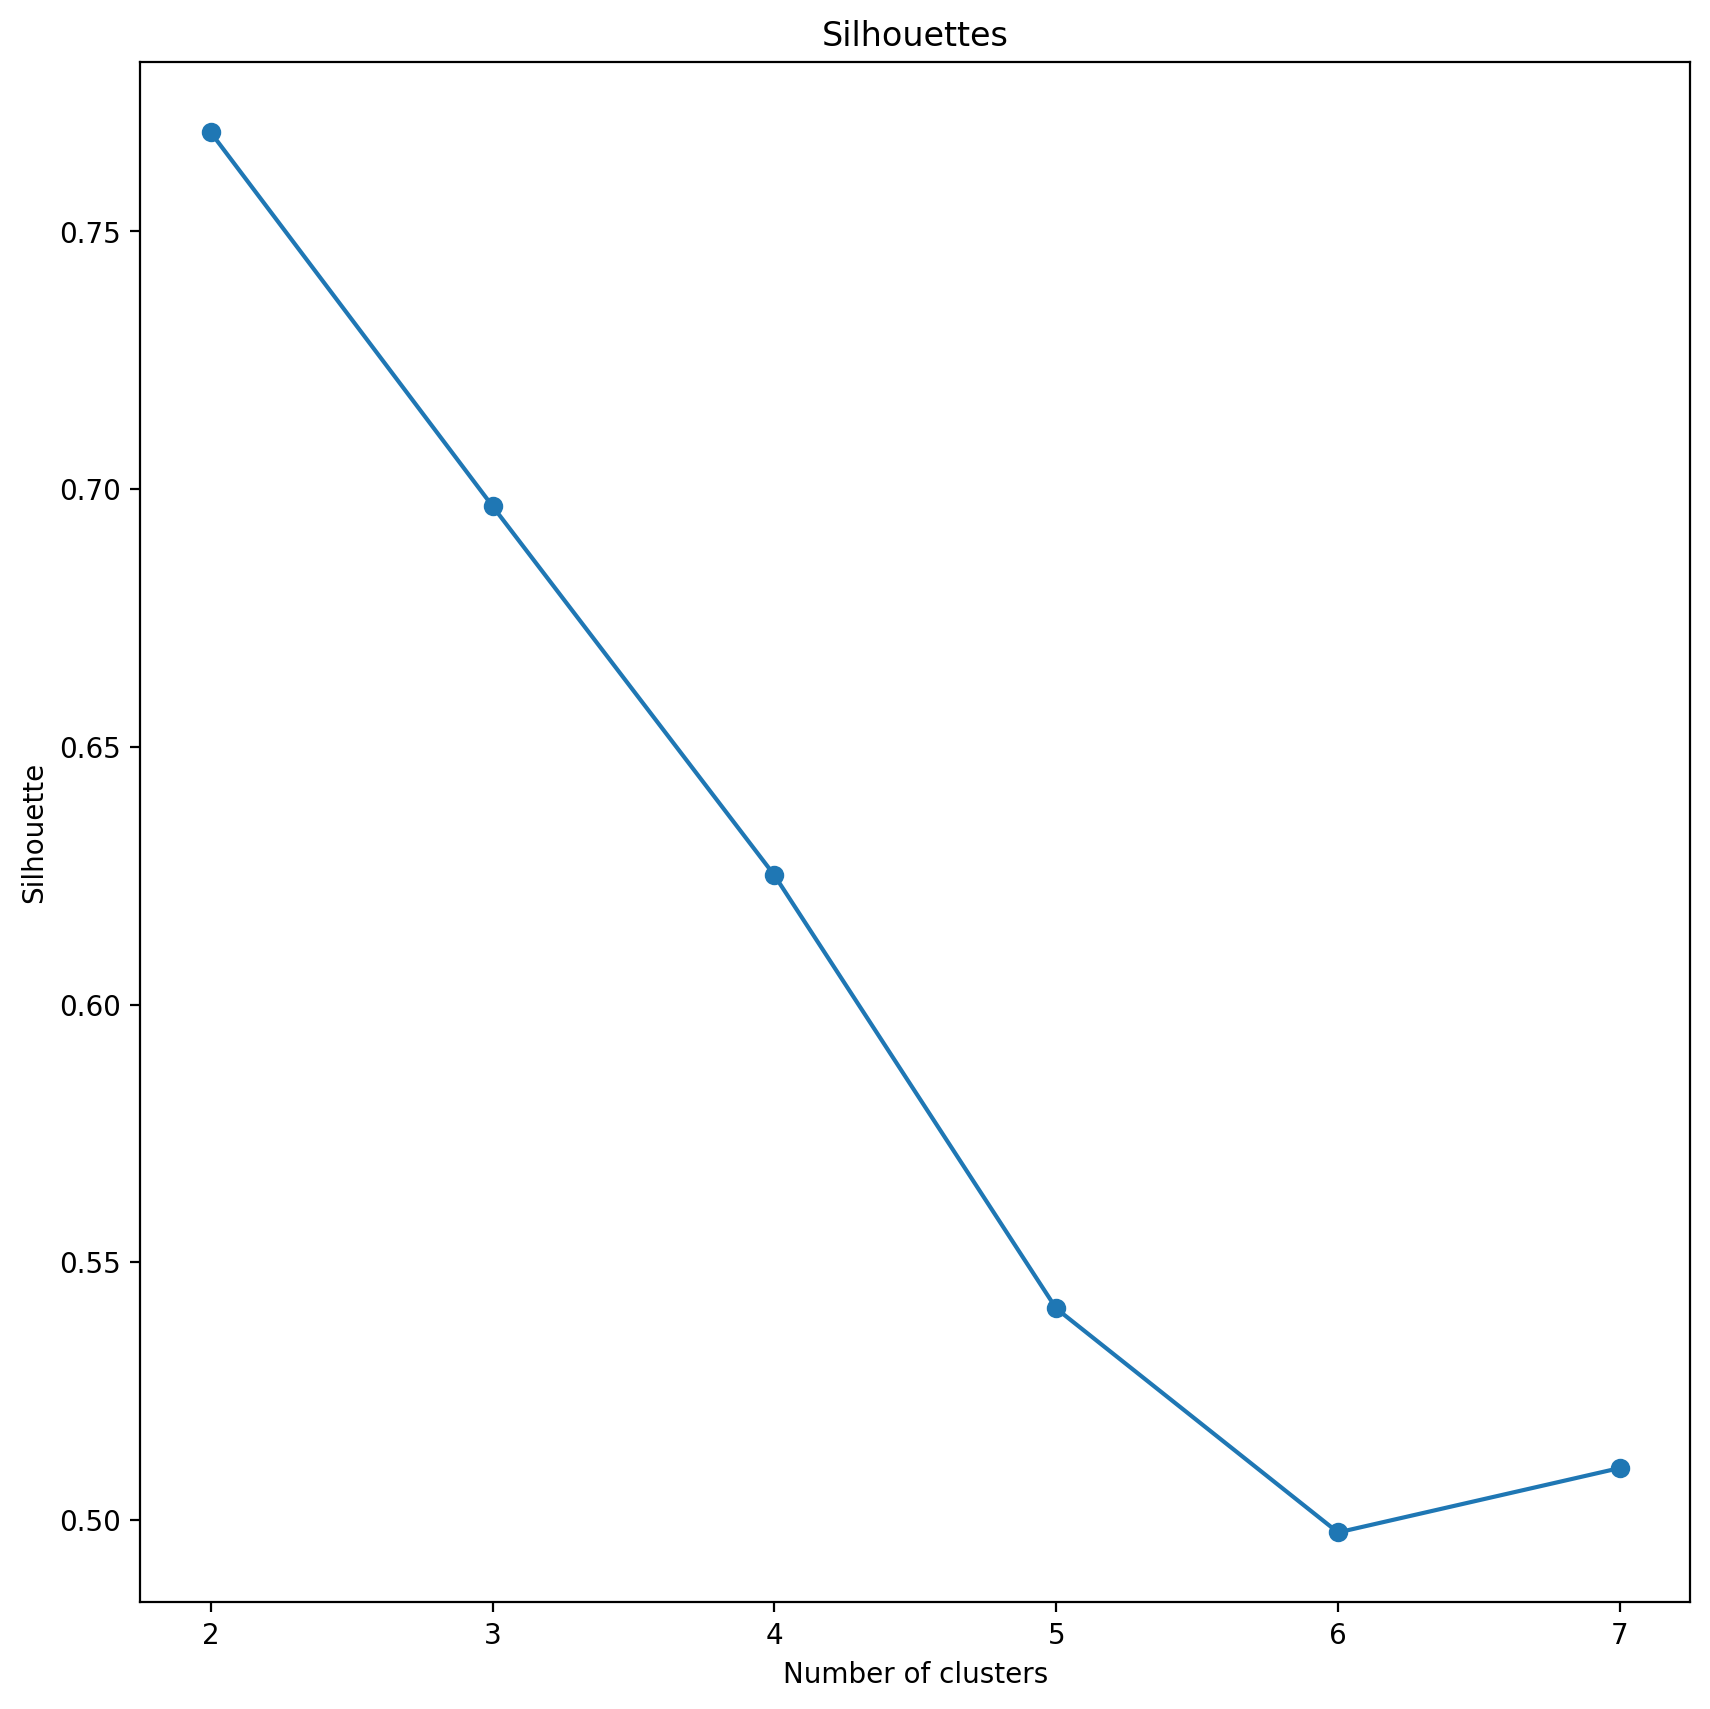

In [35]:
#distance points to the centroid of its cluster
k=range(2,8)

plt.figure(figsize=(10,10), dpi=200)

plt.plot(k, silhouettes)
plt.scatter(k, silhouettes)

plt.title('Silhouettes')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')

plt.savefig('./silhouettes_2.png')
plt.show()

In [36]:
#use 5 clusters (as best option given by Silhouette)
k=5
kmeans = KMeans(featuresCol='features', k=k)
model = kmeans.fit(data)
    
predictions_clusters5 = model.transform(data)

In [37]:
predictions_clusters5.select('*').show()

+--------------------+--------------------+--------------------+----------+
|        log_baseRent|     log_livingSpace|            features|prediction|
+--------------------+--------------------+--------------------+----------+
|0.058268908123975824|0.058268908123975824|[0.05826890812397...|         2|
| 0.04286790022717587| 0.03941300235683506|[0.04286790022717...|         2|
| 0.04305948946044701| 0.03597506712258816|[0.04305948946044...|         2|
| 0.03922071315328133| 0.04879016416943205|[0.03922071315328...|         2|
| 0.05832551029562754|0.055112990052911745|[0.05832551029562...|         2|
| 0.03246719013750141| 0.03440142671733232|[0.03246719013750...|         2|
| 0.04802796901058147|0.042992437404078994|[0.04802796901058...|         2|
|  0.0518331486400172| 0.05727785115147344|[0.05183314864001...|         2|
|0.050693114315518165| 0.03922071315328133|[0.05069311431551...|         2|
|0.055434706888100524| 0.03564702744614242|[0.05543470688810...|         2|
|0.050693114

#### Draw it with centroids + using ToPandas

In [38]:
#To draw it 
centers = model.clusterCenters()
centers

[array([0.13116558, 0.07594339]),
 array([0.08583733, 0.06483008]),
 array([0.05552753, 0.04784238]),
 array([0.26332615, 0.10215737]),
 array([0.18682063, 0.09175899])]

#### Draw number of items per cluster

In [39]:
predictions = predictions_clusters5.groupBy("prediction").count().orderBy("prediction").toPandas()
predictions

,prediction,count
0,0,38331
1,1,54962
2,2,59097
3,3,10781
4,4,25246


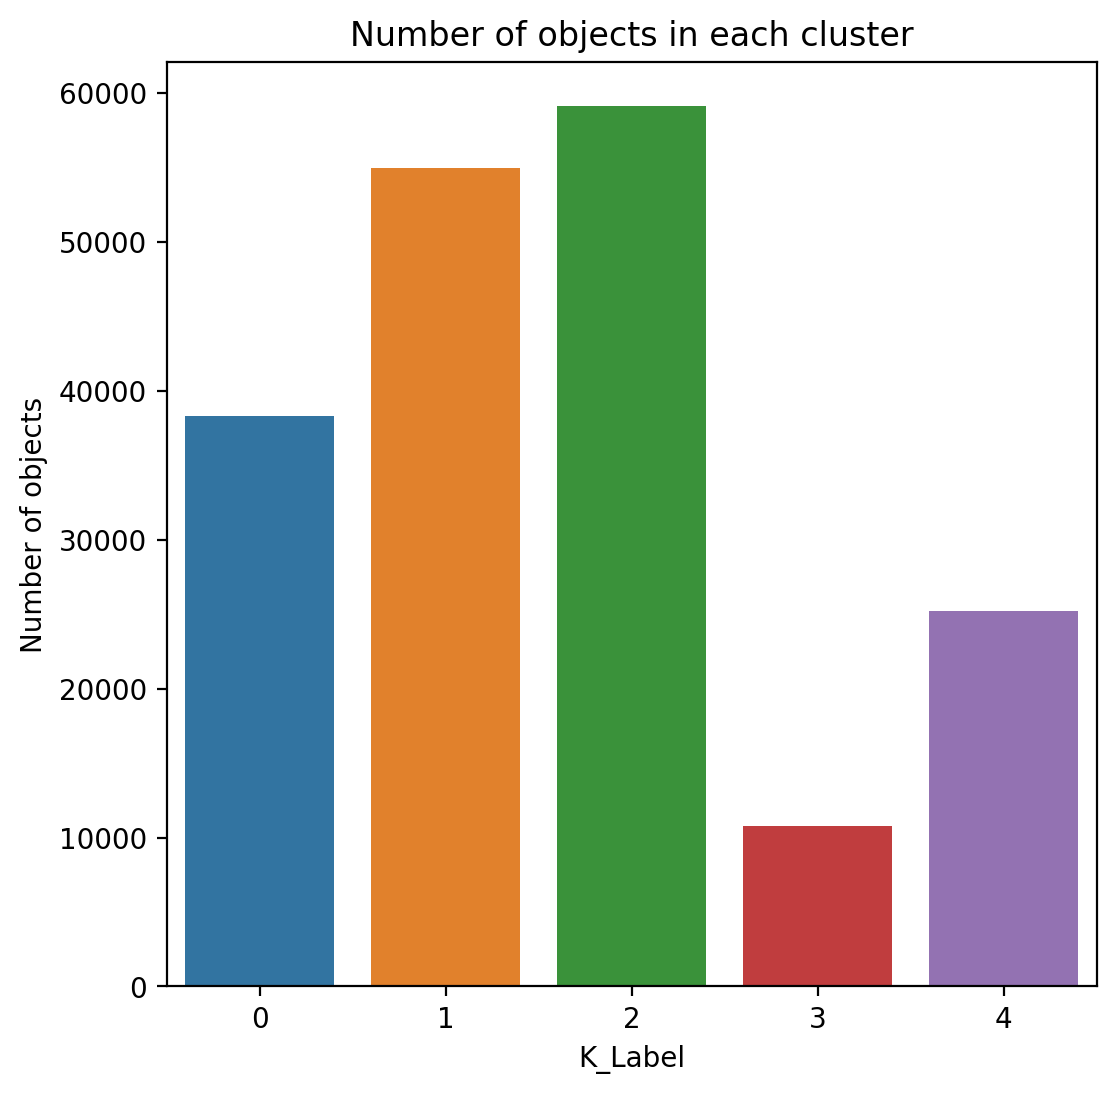

In [41]:
#to Draw, 7 clusters
predictions_clusters = predictions.set_index('prediction')
predictions_clusters

plt.figure(figsize=(6,6), dpi=200)

sns.barplot(x=predictions_clusters.index, y=predictions_clusters['count'])

plt.title('Number of objects in each cluster')
plt.ylabel('Number of objects')
plt.xlabel('K_Label')

plt.savefig('./clustering:livingSpace & BaseRent(k=5).png')
plt.show()

#### Draw the clusters with the respective centroids

In [42]:
#To draw it 
import numpy as np

centers = model.clusterCenters()
centers

#to numpy
centers=np.array(centers)

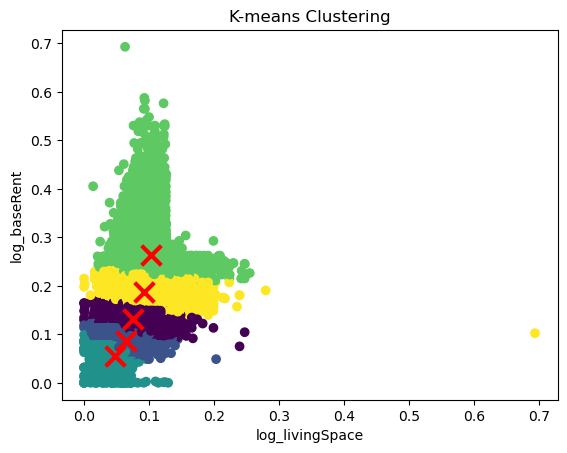

<Figure size 640x480 with 0 Axes>

In [45]:
# Spark to Pandas for visualization
clustering_result = predictions_clusters5.select('*').toPandas()

# Visualize the clusters
plt.scatter(clustering_result["log_livingSpace"], clustering_result["log_baseRent"], c=clustering_result["prediction"], cmap="viridis")

#gives error
plt.scatter(centers[:,1],centers[:,0], marker="x", s=200, linewidths=3, color='r')

plt.title("K-means Clustering")
plt.xlabel("log_livingSpace")
plt.ylabel("log_baseRent")
plt.show()
plt.savefig('./K-Mean Clustering k=5.png')

#### Clustering on 4 Attributes + PCA

In [46]:
#Reload the dataframe cleaned

# Read the CSV file with multiline values (description and facilities)
data = ss.read.options(header = True, inferSchema = True, multiline = True, escape = "\"").csv("dataframe_totalCleaned.csv")
# Show the corrected description and facilities fields
data.count(),len(data.columns)

(188417, 27)

In [47]:
#cast geo_plz (again)

from pyspark.sql.functions import col
data = data.withColumn("geo_plz", col("geo_plz").cast("string"))
data = data.withColumn("geo_plz", col("geo_plz").cast("int"))

#### Drop all no-relevant attributes

In [48]:

data_clustering3=data.drop('regio1','heatingType','balcony','firingTypes','hasKitchen',
                          'cellar','condition','interiorQual','petsAllowed','streetPlain',
                          'lift','geo_plz','garden','regio2','regio3','description',
                          'facilities','log_pictureCount','log_yearConstructed','log_noRooms',
                          'log_floor','log_numberOfFloors','typeOfFlat')

#### Attributes used for clustering

In [49]:
data_clustering3.select('*').show()

+-------------------+--------------------+--------------------+--------------------+
|  log_serviceCharge|        log_baseRent|     log_livingSpace|     log_thermalChar|
+-------------------+--------------------+--------------------+--------------------+
|0.09075436326846412|0.058268908123975824|0.058268908123975824| 0.09956940864919347|
|0.08434114843375096| 0.04286790022717587| 0.03941300235683506| 0.06013502281789924|
| 0.0769610411361284| 0.04305948946044701| 0.03597506712258816| 0.03901896805752461|
|0.04879016416943205| 0.03922071315328133| 0.04879016416943205|  0.1220493658481239|
| 0.1374287879032181| 0.05832551029562754|0.055112990052911745|0.041939328615527835|
| 0.0769610411361284| 0.03246719013750141| 0.03440142671733232| 0.08406522211322813|
|0.09866817179670123| 0.04802796901058147|0.042992437404078994|0.040472949799644324|
|0.12221763272424911|  0.0518331486400172| 0.05727785115147344|0.057519772046501785|
| 0.0769610411361284|0.050693114315518165| 0.03922071315328133| 0

#### Assembling

In [50]:
selected_data=data_clustering3.columns
# Assemble features into a single column
assembler = VectorAssembler(inputCols=selected_data, outputCol='features')
data = assembler.transform(data_clustering3)

In [51]:
data.select('*').show()

+-------------------+--------------------+--------------------+--------------------+--------------------+
|  log_serviceCharge|        log_baseRent|     log_livingSpace|     log_thermalChar|            features|
+-------------------+--------------------+--------------------+--------------------+--------------------+
|0.09075436326846412|0.058268908123975824|0.058268908123975824| 0.09956940864919347|[0.09075436326846...|
|0.08434114843375096| 0.04286790022717587| 0.03941300235683506| 0.06013502281789924|[0.08434114843375...|
| 0.0769610411361284| 0.04305948946044701| 0.03597506712258816| 0.03901896805752461|[0.07696104113612...|
|0.04879016416943205| 0.03922071315328133| 0.04879016416943205|  0.1220493658481239|[0.04879016416943...|
| 0.1374287879032181| 0.05832551029562754|0.055112990052911745|0.041939328615527835|[0.13742878790321...|
| 0.0769610411361284| 0.03246719013750141| 0.03440142671733232| 0.08406522211322813|[0.07696104113612...|
|0.09866817179670123| 0.04802796901058147|0.04

In [54]:
#Again, silhouettes and costs evaluation
silhouettes = []
costs = []

#test for 2 to 8 clusters
for k in range (2,8):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(data)
    
    predicitions = model.transform(data)
    
    # SSE to the nearest centroid a.k.a. Inertia
    cost = model.summary.trainingCost
    costs.append(cost)
    
    # sillhouette score
    evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predicitions)
    
    silhouettes.append(silhouette)

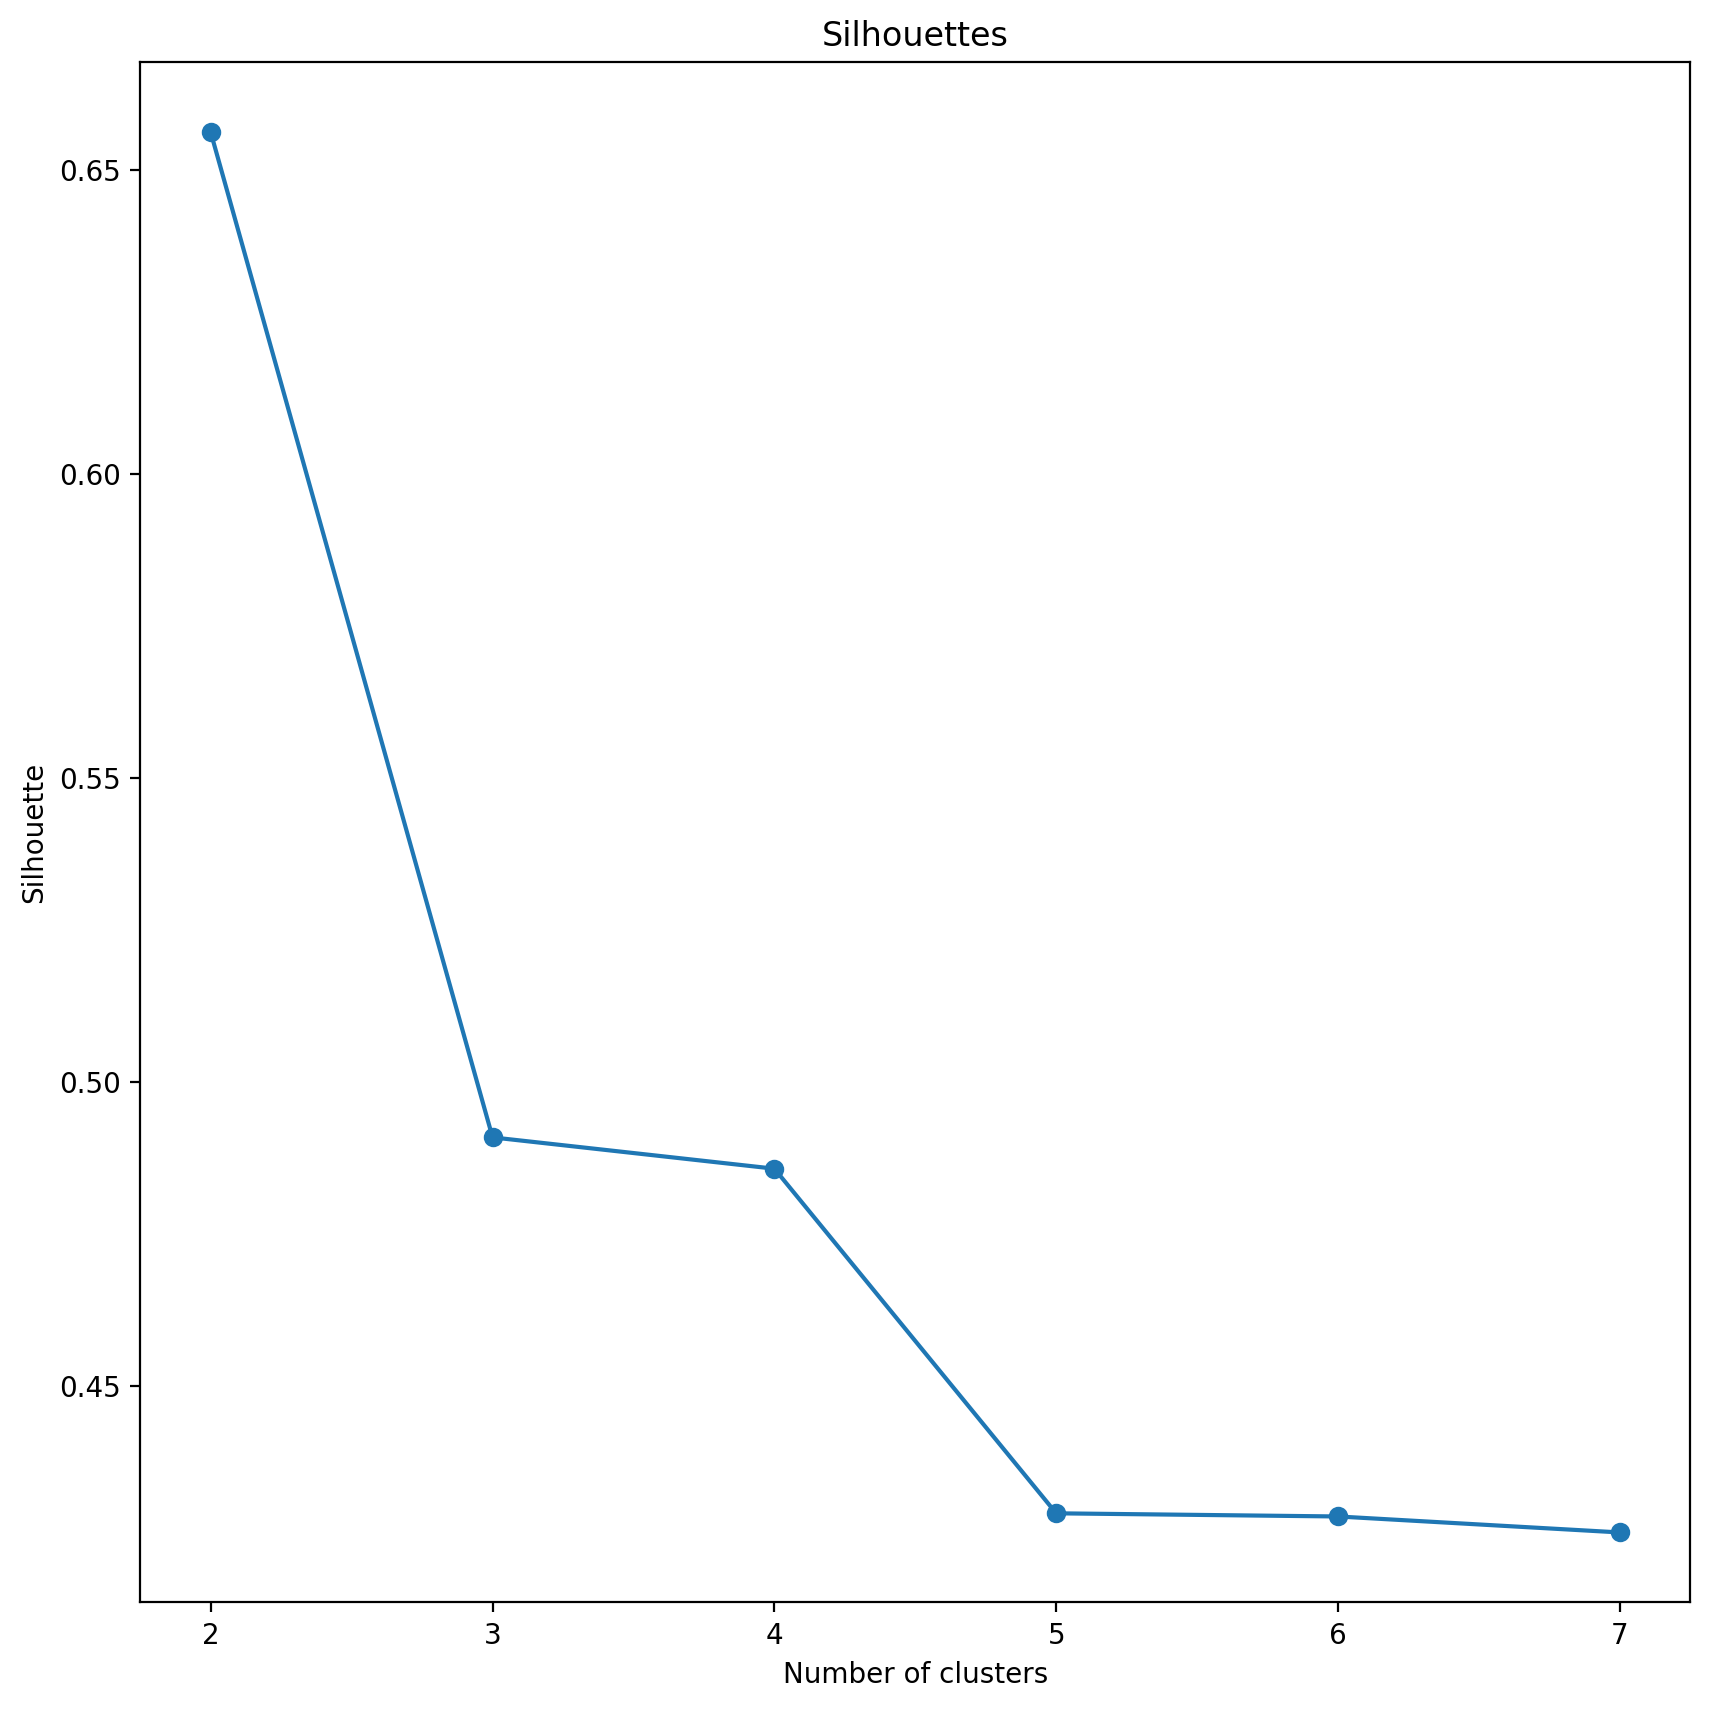

In [55]:
#distance points to the centroid of its cluster
k=range(2,8)

plt.figure(figsize=(10,10), dpi=200)

plt.plot(k, silhouettes)
plt.scatter(k, silhouettes)

plt.title('Silhouettes')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')

plt.savefig('./silhouettes_3.png')
plt.show()

In [56]:
#Run it on 3 clusters
k=3
kmeans = KMeans(featuresCol='features', k=k)
model = kmeans.fit(data)
    
predictions_clusters3 = model.transform(data)

#### Attributes per cluster

In [57]:
predictions = predictions_clusters3.groupBy("prediction").count().orderBy("prediction").toPandas()
predictions

,prediction,count
0,0,31561
1,1,89847
2,2,67009


In [58]:
predictions_clusters3.select('*').show()

+-------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  log_serviceCharge|        log_baseRent|     log_livingSpace|     log_thermalChar|            features|prediction|
+-------------------+--------------------+--------------------+--------------------+--------------------+----------+
|0.09075436326846412|0.058268908123975824|0.058268908123975824| 0.09956940864919347|[0.09075436326846...|         1|
|0.08434114843375096| 0.04286790022717587| 0.03941300235683506| 0.06013502281789924|[0.08434114843375...|         1|
| 0.0769610411361284| 0.04305948946044701| 0.03597506712258816| 0.03901896805752461|[0.07696104113612...|         1|
|0.04879016416943205| 0.03922071315328133| 0.04879016416943205|  0.1220493658481239|[0.04879016416943...|         1|
| 0.1374287879032181| 0.05832551029562754|0.055112990052911745|0.041939328615527835|[0.13742878790321...|         1|
| 0.0769610411361284| 0.03246719013750141| 0.03440142671733232| 

#### PCA in order to draw it (2 Dimensions, 3 CLusters)

In [59]:
centers = model.clusterCenters()
centers

#to numpy
centers=np.array(centers)
centers

array([[0.20921908, 0.21238779, 0.09758712, 0.04125437],
       [0.08841813, 0.06951061, 0.05273706, 0.05812515],
       [0.15372945, 0.11506698, 0.0735035 , 0.05490882]])

#### PCA on features

In [60]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(data)
pca_transformed = pca_model.transform(data)

In [61]:
pca_transformed.select('*').show()

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  log_serviceCharge|        log_baseRent|     log_livingSpace|     log_thermalChar|            features|                 pca|
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0.09075436326846412|0.058268908123975824|0.058268908123975824| 0.09956940864919347|[0.09075436326846...|[-0.1074297274019...|
|0.08434114843375096| 0.04286790022717587| 0.03941300235683506| 0.06013502281789924|[0.08434114843375...|[-0.0907596380558...|
| 0.0769610411361284| 0.04305948946044701| 0.03597506712258816| 0.03901896805752461|[0.07696104113612...|[-0.0868098240615...|
|0.04879016416943205| 0.03922071315328133| 0.04879016416943205|  0.1220493658481239|[0.04879016416943...|[-0.0623669754897...|
| 0.1374287879032181| 0.05832551029562754|0.055112990052911745|0.041939328615527835|[0.13742878790321...|[-0.14

In [62]:
import numpy as np
#get pca
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

#cluster prediction
cluster_assignments = np.array(predictions_clusters3.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

In [63]:
#represented on df
pca_data = np.hstack((x_pca, cluster_assignments))
pca_data 

array([[-0.10742973,  0.03672813,  1.        ],
       [-0.09075964,  0.03879181,  1.        ],
       [-0.08680982,  0.03128008,  1.        ],
       ...,
       [-0.08975028,  0.00775331,  1.        ],
       [-0.1447773 ,  0.04794447,  1.        ],
       [-0.11186168,  0.034771  ,  1.        ]])

#### Get the centroids in the PCA model (dot product(centroids_original * centroids_PCA))

In [64]:
centroids = pca_model.pc.toArray()
centroids 

array([[-0.65767312,  0.73765332],
       [-0.71177778, -0.66861649],
       [-0.23509523, -0.0096004 ],
       [ 0.07462366,  0.09342058]])

In [65]:
centers

array([[0.20921908, 0.21238779, 0.09758712, 0.04125437],
       [0.08841813, 0.06951061, 0.05273706, 0.05812515],
       [0.15372945, 0.11506698, 0.0735035 , 0.05490882]])

In [66]:
centroids=np.dot(centers,centroids) #A^T*T

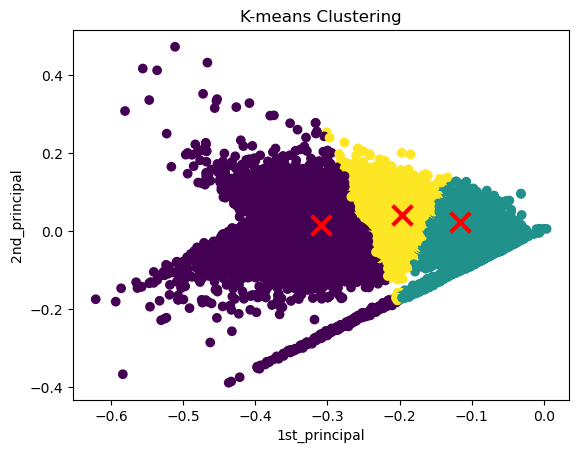

<Figure size 640x480 with 0 Axes>

In [67]:
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignments"))

plt.scatter(pca_df["1st_principal"], pca_df["2nd_principal"], c=pca_df["cluster_assignments"], cmap="viridis")
plt.scatter(centroids[:,0],centroids[:,1], marker="x", s=200, linewidths=3, color='r')

plt.title("K-means Clustering")
plt.xlabel("1st_principal")
plt.ylabel("2nd_principal")
plt.show()
plt.savefig('./K-Mean Clustering_PCA k=3.png')


plt.show()